In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ode_solver import solve_ode, Euler, EulerCromer, EulerRichardson, RungeKutta, RK45

# Define the gravitational parameter
G = 4 * np.pi**2  # in units where AU and years are used

# Circular orbit function
def circular_orbit(t, y, G):
    """
    Function for the circular orbit problem.
    y[0] = x, y[1] = vx, y[2] = y, y[3] = vy
    """
    r = np.sqrt(y[0]**2 + y[2]**2)
    r3 = r**3

    dydt = np.zeros_like(y)
    dydt[0] = y[1]  # dx/dt = vx
    dydt[1] = -G * y[0] / r3  # dvx/dt = -GM*x/r^3
    dydt[2] = y[3]  # dy/dt = vy
    dydt[3] = -G * y[2] / r3  # dvy/dt = -GM*y/r^3

    return dydt

# Initial conditions for a circular orbit
x0 = 1.0  # AU
y0 = 0.0  # AU
vx0 = 0.0  # AU/year
vy0 = np.sqrt(G/x0)  # For circular orbit, v = sqrt(GM/r)

initial_state = np.array([x0, vx0, y0, vy0])

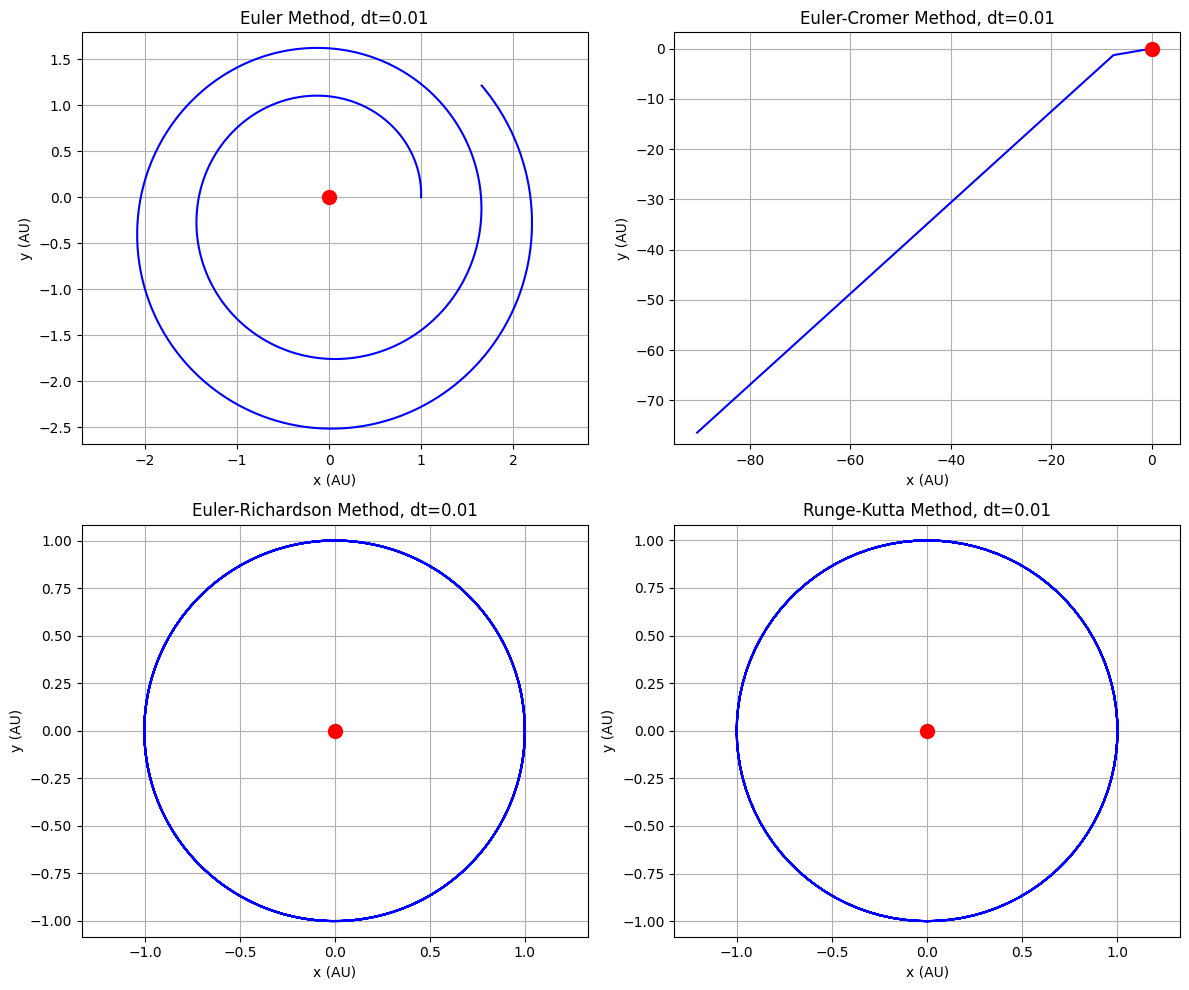

In [5]:
# Time parameters
t_span = [0, 5]  # 5 years of simulation
dt = 0.01  # Initial timestep

# Compare different methods
methods = {
    "Euler": Euler,
    "Euler-Cromer": EulerCromer,
    "Euler-Richardson": EulerRichardson,
    "Runge-Kutta": RungeKutta,
}

plt.figure(figsize=(12, 10))

for i, (name, method) in enumerate(methods.items()):
    # Pass G as a single value, not as a tuple
    t, y = solve_ode(circular_orbit, t_span, initial_state, method, G, first_step=dt)

    plt.subplot(2, 2, i+1)
    plt.plot(y[:, 0], y[:, 2], 'b-')
    plt.plot(0, 0, 'ro', markersize=10)  # The Sun
    plt.axis('equal')
    plt.grid(True)
    plt.title(f"{name} Method, dt={dt}")
    plt.xlabel("x (AU)")
    plt.ylabel("y (AU)")

plt.tight_layout()
plt.show()

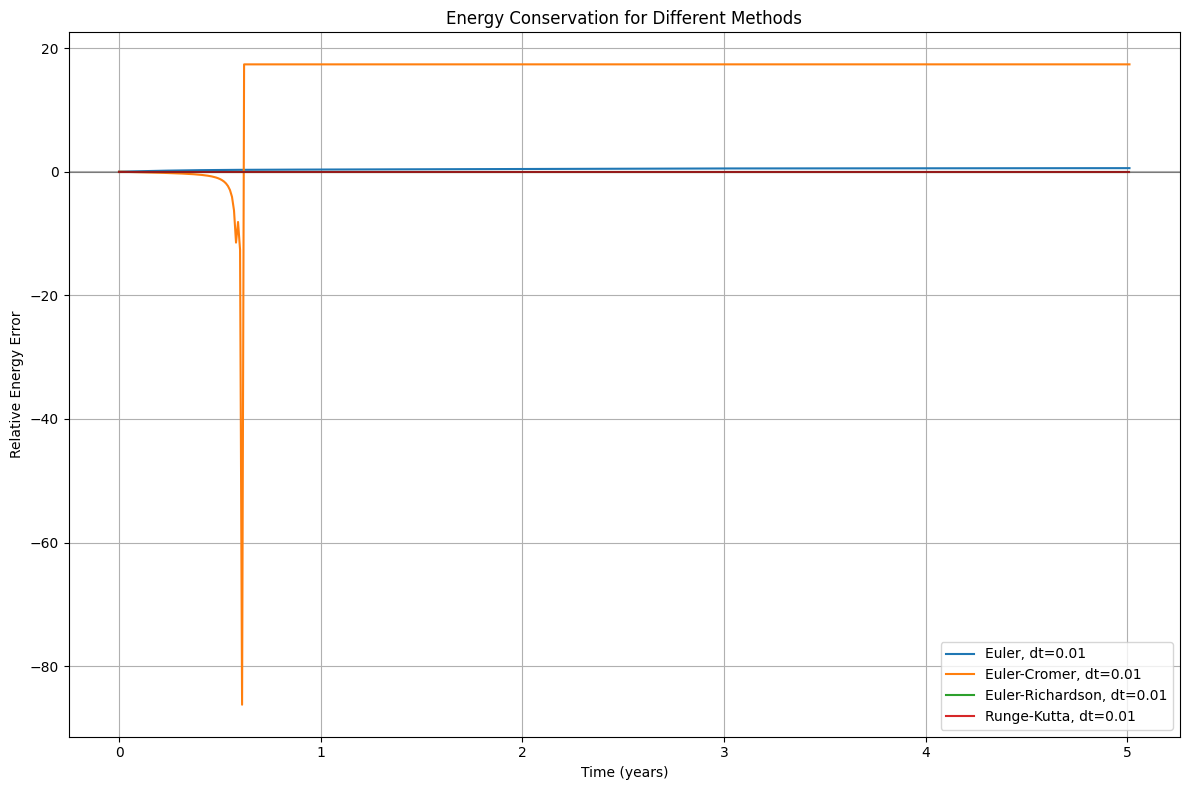

Initial energy: -19.739209
Expected energy for circular orbit: -19.739209


In [ ]:
def calculate_energy(y, G):
    """Calculate energy per unit mass"""
    r = np.sqrt(y[0]**2 + y[2]**2)
    kinetic = 0.5 * (y[1]**2 + y[3]**2)  # 0.5 * v^2
    potential = -G / r  # -GM/r with M=1
    return kinetic + potential

# Compare energy conservation for different methods
time_steps = [0.01]  # You can test with different time steps
methods = {
    "Euler": Euler,
    "Euler-Cromer": EulerCromer,
    "Euler-Richardson": EulerRichardson,
    "Runge-Kutta": RungeKutta,
}

plt.figure(figsize=(12, 8))

for dt in time_steps:
    for name, method in methods.items():
        t, y = solve_ode(circular_orbit, t_span, initial_state, method, G, first_step=dt)

        # Calculate energy at each step
        energy = np.array([calculate_energy(y_i, G) for y_i in y])

        # Calculate relative energy error
        initial_energy = energy[0]
        relative_error = (energy - initial_energy) / abs(initial_energy)

        plt.plot(t, relative_error, label=f"{name}, dt={dt}")

plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel("Time (years)")
plt.ylabel("Relative Energy Error")
plt.legend()
plt.grid(True)
plt.title("Energy Conservation for Different Methods")
plt.tight_layout()
plt.show()

# Note: For a circular orbit, the total energy should be negative
# E = K + U = 0.5*v^2 - GM/r
# For a circular orbit, v^2 = GM/r, so E = 0.5*GM/r - GM/r = -0.5*GM/r
print(f"Initial energy: {calculate_energy(initial_state, G):.6f}")
print(f"Expected energy for circular orbit: {-0.5*G/x0:.6f}")

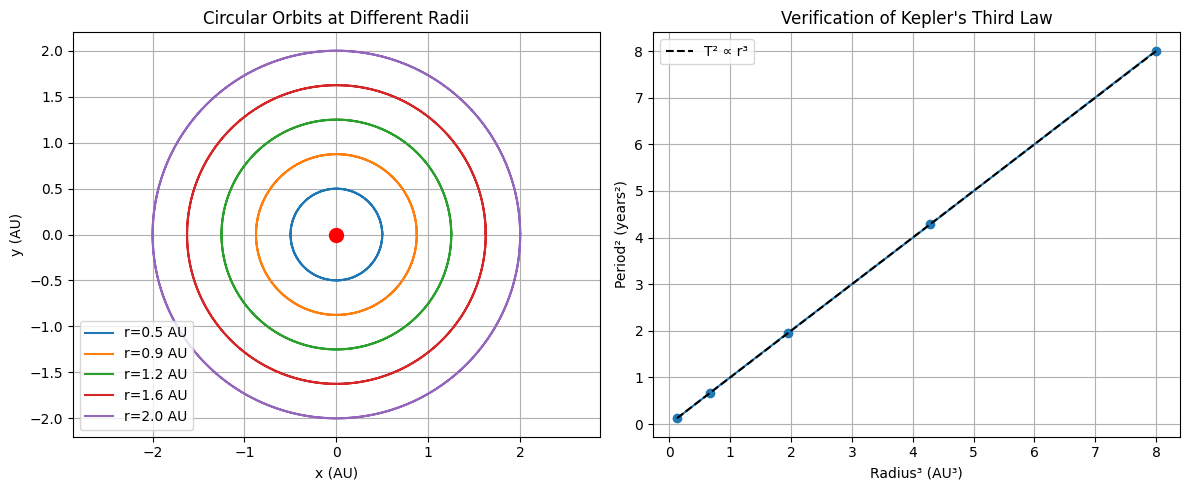

Kepler's Third Law verification:
Radius (AU)  Period (years)  T²/r³
0.50         0.35           0.9800
0.88         0.82           1.0037
1.25         1.40           1.0035
1.62         2.07           0.9986
2.00         2.83           1.0011


In [ ]:
# Test different initial radii and verify Kepler's third law
radii = np.linspace(0.5, 2.0, 5)
periods = []
orbital_radii = []

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

for radius in radii:
    # Initial conditions for circular orbit at this radius
    x0 = radius
    y0 = 0.0
    vx0 = 0.0
    vy0 = np.sqrt(G/radius)  # Circular orbit velocity
    initial_state = np.array([x0, vx0, y0, vy0])

    # Run simulation (using RungeKutta for accuracy)
    t_span = [0, 2*radius**1.5]  # Estimate period based on Kepler's third law
    dt = 0.01
    t, y = solve_ode(circular_orbit, t_span, initial_state, RungeKutta, G, first_step=dt)

    # Plot orbit
    plt.plot(y[:, 0], y[:, 2], label=f"r={radius:.1f} AU")

    # Find period (crossing from y<0 to y>0 along +x axis)
    crossings = []
    for i in range(1, len(t)):
        if y[i-1, 2] < 0 and y[i, 2] >= 0 and y[i, 0] > 0:
            crossings.append(t[i])

    if len(crossings) >= 2:
        period = crossings[1] - crossings[0]
        periods.append(period)
        orbital_radii.append(radius)

plt.plot(0, 0, 'ro', markersize=10)  # The Sun
plt.axis('equal')
plt.grid(True)
plt.title("Circular Orbits at Different Radii")
plt.xlabel("x (AU)")
plt.ylabel("y (AU)")
plt.legend()

# Plot Period^2 vs Radius^3 to verify Kepler's third law
plt.subplot(1, 2, 2)
periods_squared = np.array(periods)**2
radii_cubed = np.array(orbital_radii)**3

plt.plot(radii_cubed, periods_squared, 'o-')
plt.plot([min(radii_cubed), max(radii_cubed)],
         [min(radii_cubed), max(radii_cubed)], 'k--',
         label="T² ∝ r³")
plt.grid(True)
plt.title("Verification of Kepler's Third Law")
plt.xlabel("Radius³ (AU³)")
plt.ylabel("Period² (years²)")
plt.legend()

plt.tight_layout()
plt.show()

# Calculate the ratio T²/r³, which should be constant
ratios = periods_squared / radii_cubed
print("Kepler's Third Law verification:")
print("Radius (AU)  Period (years)  T²/r³")
for r, p, ratio in zip(orbital_radii, periods, ratios):
    print(f"{r:.2f}         {p:.2f}           {ratio:.4f}")